# Tequila circuit conversion to PyZX and viceversa

[PyZX](https://github.com/Quantomatic/pyzx) (pronounce as Pisics) is a Python tool implementing the theory of ZX-calculus for the creation, visualisation, and automated rewriting of large-scale quantum circuits.

The [ZX-calculus](https://en.wikipedia.org/wiki/ZX-calculus) is a rigorous graphical language for reasoning about linear maps between qubits, which are represented as *ZX-diagrams*. A ZX-diagram consists of a set of generators called *spiders* that represent specific tensors. 

Due to the symmetries of the spiders and the properties of the underlying category, topologically deforming a ZX-diagram (i.e. moving the generators without changing their connections) does not affect the linear map it represents. The ZX-calculus also has a set of graphical rewrite rules for transforming ZX-diagrams into one another. The ZX-calculus is universal in the sense that any linear map between qubits can be represented as a ZX-diagram, and different sets of graphical rewrite rules are complete for different families of linear maps. ZX-diagrams can be seen as a generalisation of quantum circuit notation.

## Convert to PyZX circuit

### Note: If you don't have the [PyZX](https://github.com/Quantomatic/pyzx) package installed, this tutorial won't work

Once you have a circuit in Tequila, it is possible to convert it to its equivalent in PyZX circuit, using the `convert_to_pyzx` function, for example:

In [1]:
import tequila as tq
from numpy import pi

In [2]:
circuit = tq.gates.H(target=[0,1]) + \
          tq.gates.X(target=0) + \
          tq.gates.Z(target=2) + \
          tq.gates.CX(target=3, control=0) + \
          tq.gates.Rz(target=2, angle=pi/5)

tq.draw(circuit)

0: ───H───X──────────@───
                     │
1: ───H──────────────┼───
                     │
2: ───Z───Rz(0.2π)───┼───
                     │
3: ──────────────────X───


In [3]:
pyzx_cir = tq.convert_to_pyzx(circuit)

Once you have the pyzx circuit, you can use the functionality of the package to manipulate the circuit.

In [4]:
import pyzx as zx

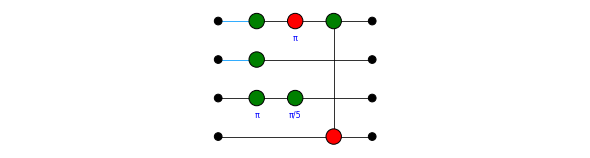

In [5]:
# indicate drawing mode for PyZX
zx.settings.drawing_backend = 'matplotlib' # could be 'd3' and will use the D3 Javascript library
                                           # to generate a more interactive representation

zx.draw(pyzx_cir)

The blue lines represent edges that have a Hadamard gate on them.

In the picture above we see the ZX-diagram of the original quantum circuit.
A ZX-diagram is a graphical representation of a linear map between qubits that evoke a conventional quantum circuit.

### Parametrized Circuits

If the Tequila circuit is created with variables, the corresponding values must explicitly given when converting to a PyZX circuit:

In [6]:
circuit_var = tq.gates.H(target=[0,1]) + \
              tq.gates.X(target=0) + \
              tq.gates.Z(target=2) + \
              tq.gates.CX(target=3, control=0) + \
              tq.gates.Rz(target=2, angle="var1") + \
              tq.gates.Rx(target=0, angle="var2")

tq.draw(circuit_var)

0: ───H───X───────────────────────────────────────@───Rx(0.318309886183791*pi*f((var2,))_1)───
                                                  │
1: ───H───────────────────────────────────────────┼───────────────────────────────────────────
                                                  │
2: ───Z───Rz(0.318309886183791*pi*f((var1,))_0)───┼───────────────────────────────────────────
                                                  │
3: ───────────────────────────────────────────────X───────────────────────────────────────────


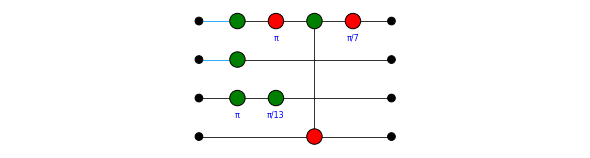

In [7]:
variables = {"var1":pi/13, "var2": pi/7}

pyzx_cir_var = tq.convert_to_pyzx(circuit_var, variables=variables)

zx.draw(pyzx_cir_var)

Since there are no `Y` gates (`Y`, `Ry`, `Cy`, `CRy`) in ZX-calculus, the conversion of a Tequila circuit to a PyZX circuit includes the transformation of said gates to their equivalents in 'X' and 'Z' rotations, for example

0: ───Y───


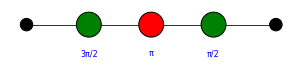

In [8]:
circuit_y = tq.gates.Y(target=0)

tq.draw(circuit_y)

pyzx_cir_y = tq.convert_to_pyzx(circuit_y)

zx.draw(pyzx_cir_y, figsize=(4,0.5))

0: ───Ry(1.23π)───


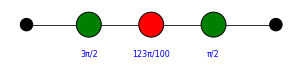

In [9]:
circuit_ry = tq.gates.Ry(target=0, angle=1.23*pi)

tq.draw(circuit_ry)

pyzx_cir_ry = tq.convert_to_pyzx(circuit_ry)

zx.draw(pyzx_cir_ry, figsize=(4,0.5))

## Convert from PyZX circuit

You can convert a PyZX circuit to a Tequila circuit with the help of the `convert_from_pyzx` function, for example:

In [10]:
tequila_cir = tq.convert_from_pyzx(pyzx_cir)

tq.draw(tequila_cir)

0: ───H───X──────────@───
                     │
1: ───H──────────────┼───
                     │
2: ───Z───Rz(0.2π)───┼───
                     │
3: ──────────────────X───


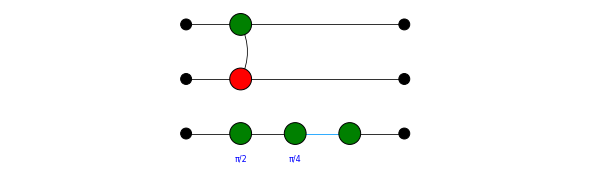

In [11]:
pyzx_circuit = zx.Circuit(qubit_amount=3)  # creates a new PyZX circuit
pyzx_circuit.add_gates("S T HAD", 2)
pyzx_circuit.add_gate("CNOT", 0, 1)

zx.draw(pyzx_circuit)

In [12]:
tequila_circuit = tq.convert_from_pyzx(pyzx_circuit)

tq.draw(tequila_circuit)

0: ───@──────────────────────────
      │
1: ───X──────────────────────────

2: ───Rz(0.5π)───Rz(0.25π)───H───


## Optimizations with PyZX

The main function of PyZX is the ability to optimize quantum circuits. The main optimization methods work by converting a circut into a ZX-diagram, simplifying this diagram, and then converting it back into a quantum circuit. This process is explained below.

### Optimizing circuits

PyZX allow the simplification of quantum circuits via a translation to the ZX-calculus.

For the following example, we will create a circuit in Tequila first, then convert it to a PyZX circuit.

In [13]:
cir_tequila = tq.gates.X(target=4) + \
              tq.gates.H(target=4) + \
              tq.gates.CZ(target=4, control=[0, 3]) + \
              tq.gates.CZ(target=4, control=[2, 3]) + \
              tq.gates.H(target=4) + \
              tq.gates.CX(target=4, control=3) + \
              tq.gates.H(target=4) + \
              tq.gates.CZ(target=4, control=[1, 2]) + \
              tq.gates.H(target=4) + \
              tq.gates.CX(target=4, control=2) + \
              tq.gates.H(target=4) + \
              tq.gates.CZ(target=4, control=[0, 1]) + \
              tq.gates.H(target=4) + \
              tq.gates.CX(target=4, control=1) + \
              tq.gates.CX(target=4, control=0)

tq.draw(cir_tequila)

0: ───────────@───────────────────────────────────@───────────@───
              │                                   │           │
1: ───────────┼───────────────────@───────────────@───────@───┼───
              │                   │               │       │   │
2: ───────────┼───@───────────────@───────@───────┼───────┼───┼───
              │   │               │       │       │       │   │
3: ───────────@───@───────@───────┼───────┼───────┼───────┼───┼───
              │   │       │       │       │       │       │   │
4: ───X───H───Z───Z───H───X───H───Z───H───X───H───Z───H───X───X───


This time we choose an alternative way of drawing the circuit in PyZX, with a slight difference in the notation for the Hadamard gate (more in [this demo](https://github.com/Quantomatic/pyzx/blob/master/demos/AllFeatures.ipynb)):

Original T-count: 28


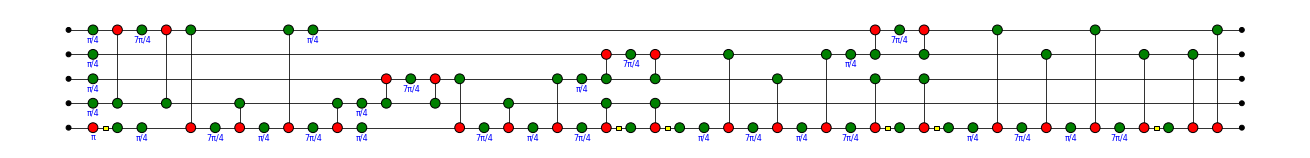

In [14]:
c = tq.convert_to_pyzx(cir_tequila)

print("Original T-count:", zx.tcount(c))

zx.draw_matplotlib(c, figsize=(18,2), h_edge_draw='box')

The green and red nodes represent Z- and X-phase gates respectively, the yellow boxes are Hadamard gates, and the vertical lines going between two different colored nodes are CNOT gates.

Using `to_basic_gates()` a version of the circuit is generated with each gate expanded in terms of X/Z phases, Hadamards and the 2-qubit gates CNOT, CZ, CX:

In [15]:
c = c.to_basic_gates()

To use the ZX-diagram simplification routines, the circuit must first be converted to a ZX-diagram:

In [16]:
g = c.to_graph()

Now we can use any of the simplification strategies built into PyZX for ZX-diagrams. The most powerful of these is `full_reduce`:

In [17]:
zx.full_reduce(g, quiet=False)

spider_simp: 13. 8. 5. 3. 2. 1.  6 iterations
id_simp: 3.  1 iterations
spider_simp: 3.  1 iterations
pivot_simp: 1. 1.  2 iterations
pivot_gadget_simp: 11. 6. 1. 1. 1.  5 iterations
id_simp: 8.  1 iterations
spider_simp: 1. 1. 3. 1.  4 iterations
gadget_simp: 4.  1 iterations
lcomp_simp: 4. 4.  2 iterations


Optimized T-count: 8


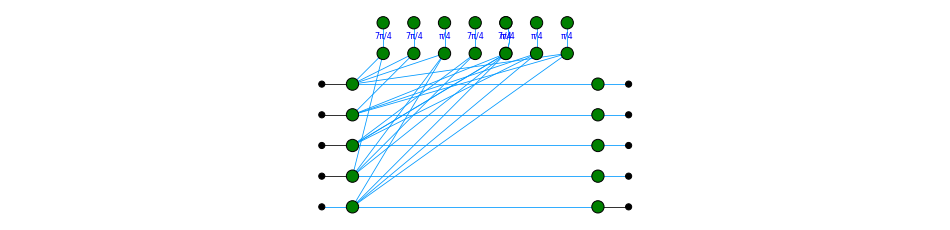

In [18]:
g.normalize() # Makes the graph more suitable for displaying
print("Optimized T-count:", zx.tcount(g))
zx.draw(g, figsize=(13,3))

That has reduced the T-count from 28 down to 8!

Reliable quantum circuits must be able to tolerate noise errors. Fault tolerant
quantum gates (such as Clifford+T gates) and quantum error correcting codes can be used to make
quantum circuits resistant to noise errors. However, the increased tolerance
to noise errors comes with the increased implementation overhead associated with the quantum T
gate. Because of the increased cost to realize the T gate, **T-count** has become an
important performance measure for fault tolerant quantum circuit design. [E. Muñoz-Coreas and H. Thapliyal, 2010](https://arxiv.org/pdf/1712.08254.pdf)

The next step is to turn this graph back into a circuit (in PyZX) and finally into a Tequila circuit.

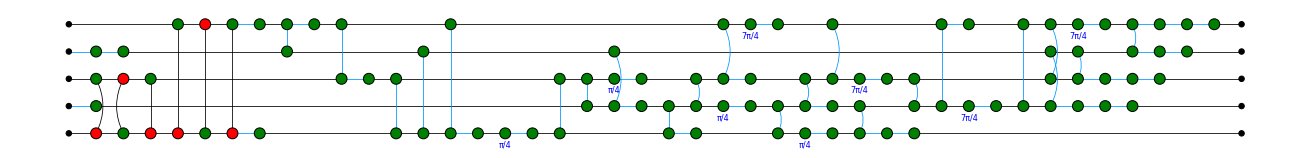

In [19]:
c_optimized = zx.extract_circuit(g.copy())

zx.draw(c_optimized, figsize=(18,2))

In [20]:
print(c_optimized.stats())

Circuit  on 5 qubits with 66 gates.
        8 is the T-count
        58 Cliffords among which 
        24 2-qubit gates (0 CNOT, 24 other) and
        34 Hadamard gates.


In [21]:
tequila_circuit_optimized = tq.convert_from_pyzx(c_optimized)

tq.draw(tequila_circuit_optimized, backend='symbolic')

circuit: 
X(target=(4,), control=(2,))
X(target=(2,), control=(4,))
X(target=(4,), control=(2,))
X(target=(4,), control=(0,))
X(target=(0,), control=(4,))
X(target=(4,), control=(0,))
H(target=(4,))
H(target=(3,))
H(target=(1,))
H(target=(0,))
H(target=(1,))
Z(target=(1,), control=(0,))
H(target=(0,))
Z(target=(2,), control=(0,))
H(target=(2,))
Z(target=(4,), control=(2,))
Z(target=(4,), control=(1,))
Z(target=(4,), control=(0,))
H(target=(4,))
Rz(target=(4,), parameter=0.7853981633974483)
H(target=(4,))
Z(target=(4,), control=(2,))
Z(target=(3,), control=(2,))
Z(target=(3,), control=(1,))
Rz(target=(2,), parameter=0.7853981633974483)
H(target=(3,))
H(target=(2,))
Z(target=(4,), control=(3,))
Z(target=(3,), control=(2,))
Z(target=(2,), control=(0,))
Rz(target=(3,), parameter=0.7853981633974483)
Rz(target=(0,), parameter=5.497787143782138)
H(target=(3,))
H(target=(0,))
H(target=(4,))
H(target=(2,))
Z(target=(4,), control=(3,))
Z(target=(3,), control=(2,))
Z(target=(2,), control=(0,))
Rz